# Project Introduction

Sweet Lift Taxi has collected historical data on hourly taxi orders from an airport. To help attract more drivers during periods of high demand, the company is looking to forecast the number of taxi orders for the upcoming hour. A reliable prediction model will support smarter driver allocation and reduce customer wait times.

The task is to build a predictive model that forecasts the number of taxi orders one hour into the future. The model will be evaluated using the Root Mean Squared Error (RMSE) metric, and must achieve an RMSE of 48 or lower on the test set to be considered successful.

## Import libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error
#from sklearn.metrics import root_mean_squared_error

from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.ar_model import AutoReg, ar_select_order
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import arma_order_select_ic

from pmdarima import auto_arima
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [2]:
# Checking if root_mean_squared_error will work in this environment
import sklearn
print(sklearn.__version__)

1.5.1


sklearn.metrics.root_mean_squared_error was introducted in scikit-learn 1.4 and it looks like the version running in this environment is older. https://scikit-learn.org/stable/modules/generated/sklearn.metrics.root_mean_squared_error.html so I'll update things to work with mean_squared_error.

## Helper Functions

In [3]:
# Initialize a list for storing all the results
model_results = []

def track_model_result(name, description, y_true, y_pred, results_list):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred) # for personal exploration
    print(f"{name} RMSE:", rmse.round(3))
    
    results_list.append({
        'Model': name,
        'Description': description,
        'RMSE': rmse,
        'MAE': mae
    })

# Data Preparation

## Load and Inspect the Data

In [4]:
try: 
    data = pd.read_csv('./datasets/taxi.csv')
    print("Loaded data locally")
except Exception as e_local:
    try:
        data = pd.read_csv('https://practicum-content.s3.us-west-1.amazonaws.com/datasets/taxi.csv')
        print("Loaded data from the server")
    except Exception as e_server:
        print("Unable to load data from both local and server sources.")

Loaded data locally


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26496 entries, 0 to 26495
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   datetime    26496 non-null  object
 1   num_orders  26496 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 414.1+ KB


In [6]:
data.isna().sum()

datetime      0
num_orders    0
dtype: int64

In [7]:
data.head()

,datetime,num_orders
0,2018-03-01 00:00:00,9
1,2018-03-01 00:10:00,14
2,2018-03-01 00:20:00,28
3,2018-03-01 00:30:00,20
4,2018-03-01 00:40:00,32


Each original row is at 10-minute intervals: the number of orders during that 10-minute period.

## Convert the datetime and sort

In [8]:
# Convert `datetime`
data['datetime'] = pd.to_datetime(data['datetime'])

In [9]:
data.set_index('datetime', inplace=True)

In [10]:
data = data.sort_index()

In [11]:
# check dates and times are in chronological order
try:
    is_mono = data.index.is_monotonic_increasing
except AttributeError:
    is_mono = data.index.is_monotonic  # fallback for older pandas

print("Is index monotonic:", is_mono)

Is index monotonic: True


In [12]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


## Resample

In [13]:
# Resample for hourly intervals
data_resampled = data.resample('1h').sum()

As th goal of the project is to attract more drivers during peak hours, we need to predict the amount of taxi orders for the next hour. 

I resampled the data for hourly intervals and used sum as this gives us the total number of orders per hour, our target metric. 

In [14]:
# Checking our work
data_resampled.head()

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43


In [15]:
data_resampled.describe()

,num_orders
count,4416.000000
mean,84.422781
std,45.023853
min,0.000000
25%,54.000000
50%,78.000000
75%,107.000000
max,462.000000


In [16]:
data_resampled.isna().sum()

num_orders    0
dtype: int64

In [17]:
data_resampled.index.min(), data_resampled.index.max()
print("Earliest timestamp:", data_resampled.index.min())
print("Latest timestamp:", data_resampled.index.max())
print("Total duration:", data_resampled.index.max() - data_resampled.index.min())

Earliest timestamp: 2018-03-01 00:00:00
Latest timestamp: 2018-08-31 23:00:00
Total duration: 183 days 23:00:00


# Exploratory Data Analysis

## Visualize the Raw Data

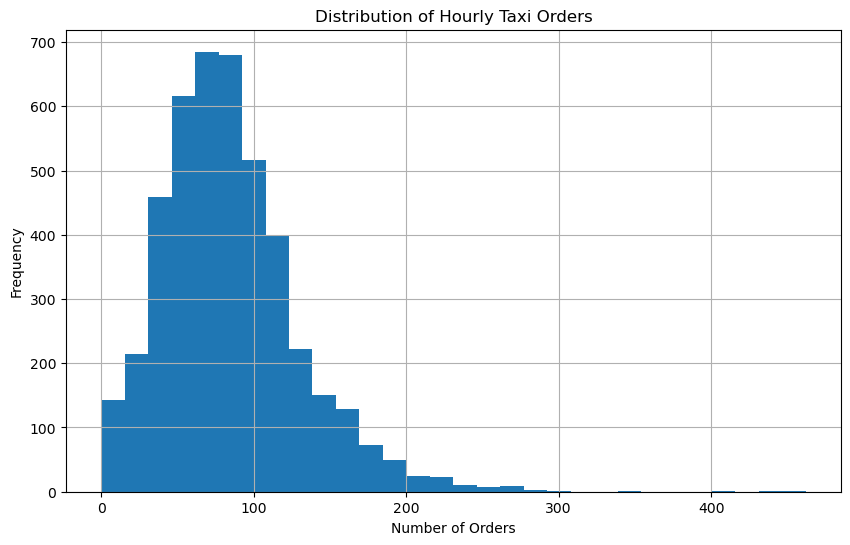

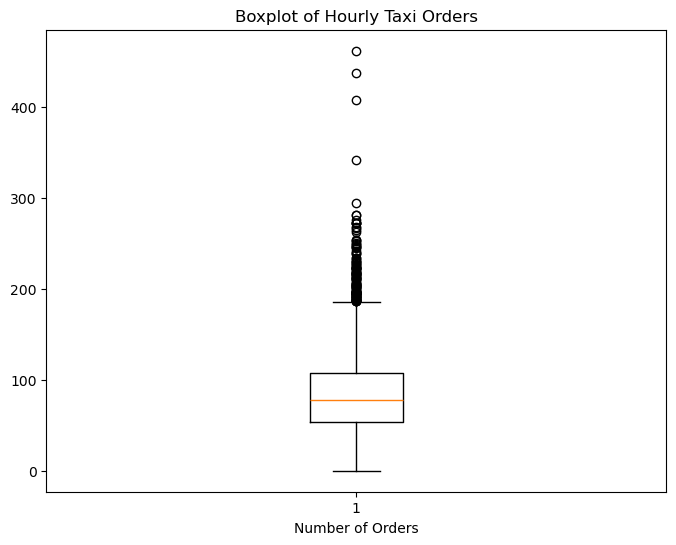

In [18]:
#Histo
plt.figure(figsize=(10, 6))
data_resampled['num_orders'].hist(bins=30)
plt.title('Distribution of Hourly Taxi Orders')
plt.xlabel('Number of Orders')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()


# boxplot
plt.figure(figsize=(8, 6))
plt.boxplot(data_resampled['num_orders'])
plt.title('Boxplot of Hourly Taxi Orders')
plt.xlabel('Number of Orders')
plt.show()

In [19]:
# Investigate the outliers 
data_resampled.sort_values('num_orders', ascending=False).head(10)

,num_orders
datetime,
2018-08-20 02:00:00,462
2018-08-13 02:00:00,437
2018-08-27 02:00:00,408
2018-08-30 17:00:00,342
2018-08-27 04:00:00,295
2018-08-18 00:00:00,281
2018-08-26 00:00:00,281
2018-08-31 00:00:00,276
2018-08-13 01:00:00,273


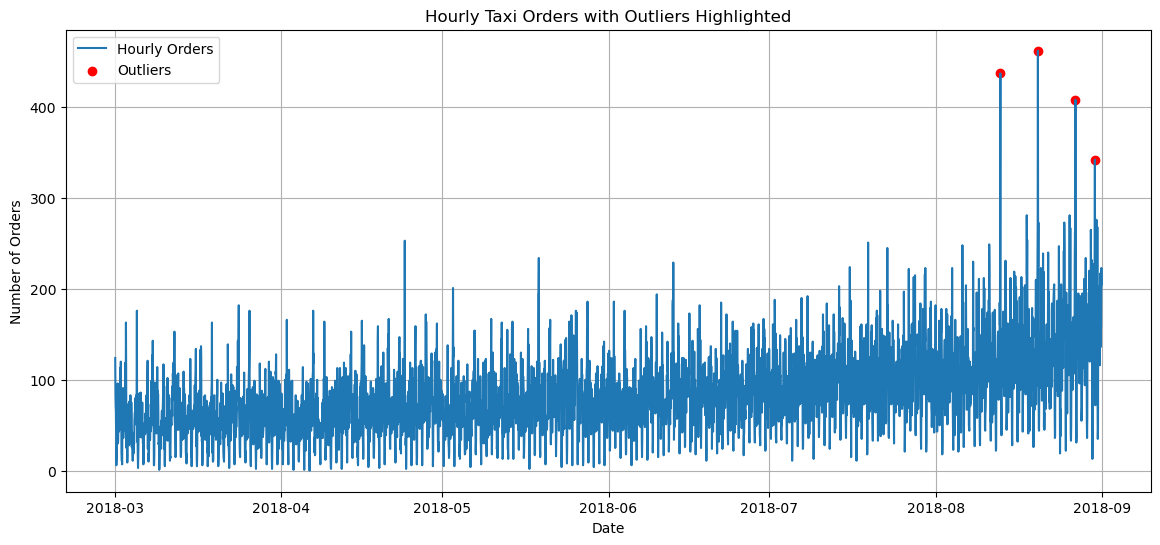

In [20]:
top_outliers = data_resampled[data_resampled['num_orders'] > 300]

plt.figure(figsize=(14, 6))
plt.plot(data_resampled.index, data_resampled['num_orders'], label='Hourly Orders')
plt.scatter(top_outliers.index, top_outliers['num_orders'], color='red', label='Outliers')
plt.title('Hourly Taxi Orders with Outliers Highlighted')
plt.xlabel('Date')
plt.ylabel('Number of Orders')
plt.legend()
plt.grid(True)
plt.show()

The top 3 extreme outliers are at 2 AM. I'm going to clip the data, but I'm not quite sure where yet...

In [21]:
q95 = data_resampled['num_orders'].quantile(0.95)
q99 = data_resampled['num_orders'].quantile(0.99)

print("95th percentile:", q95)
print("99th percentile:", q99)

95th percentile: 166.0
99th percentile: 223.0


In [22]:
outliers = data_resampled['num_orders'] > 223
print(outliers.sum())

42


This number of values seems high, so I'm going to manually clip the outliers at 300. 

### Clip the outliers

In [23]:
data_resampled['num_orders_clipped'] = data_resampled['num_orders'].clip(upper=300)
data_resampled['is_clipped'] = (data_resampled['num_orders'] > 300).astype(int) # Not sure if I'll want this later

In [24]:
data_resampled.head()

,num_orders,num_orders_clipped,is_clipped
datetime,,,
2018-03-01 00:00:00,124,124,0
2018-03-01 01:00:00,85,85,0
2018-03-01 02:00:00,71,71,0
2018-03-01 03:00:00,66,66,0
2018-03-01 04:00:00,43,43,0


## Trends and Seasonality

###  Rolling Mean

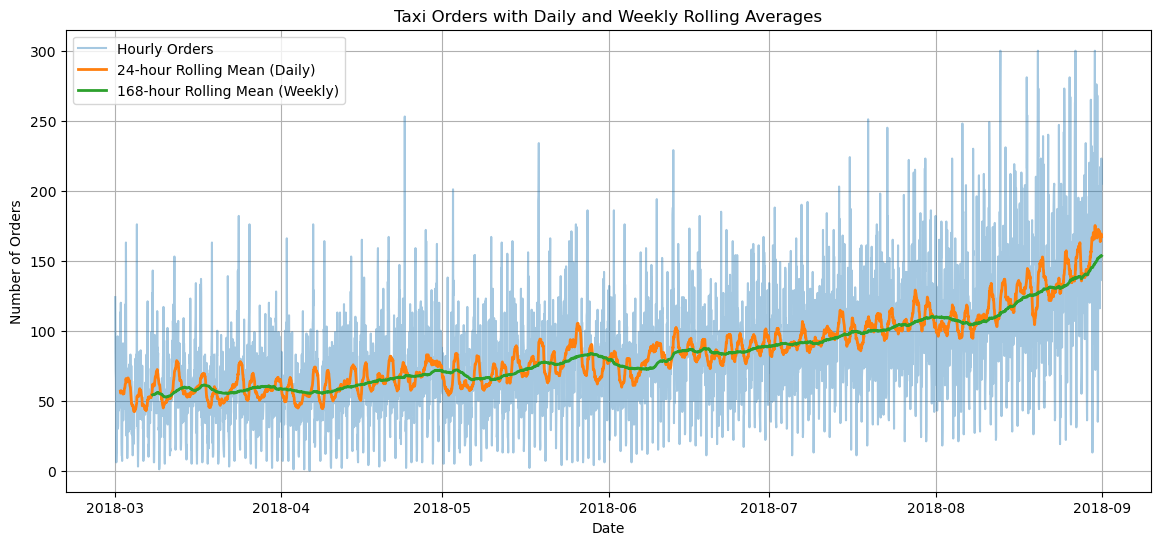

In [25]:
data_resampled['rolling_24'] = data_resampled['num_orders_clipped'].rolling(24).mean() # Daily 
data_resampled['rolling_168'] = data_resampled['num_orders_clipped'].rolling(168).mean() # Weekly

plt.figure(figsize=(14, 6))
plt.plot(data_resampled['num_orders_clipped'], label='Hourly Orders', alpha=0.4)
plt.plot(data_resampled['rolling_24'], label='24-hour Rolling Mean (Daily)', linewidth=2)
plt.plot(data_resampled['rolling_168'], label='168-hour Rolling Mean (Weekly)', linewidth=2)
plt.title('Taxi Orders with Daily and Weekly Rolling Averages')
plt.xlabel('Date')
plt.ylabel('Number of Orders')
plt.legend()
plt.grid(True)
plt.show()


The data shows a clear upward trend in both the daily and weekly rolling averages, indicating a changing mean over time. 

The spread of the data and the amplitude of daily fluctuations also increase, suggesting the variance is not constant. This means the time series is not stationary.

    
- Hourly:
    - Noisy with high spikes at the end (the extreme fluctuations indicate a change in variance = non-stationary). 

- Daily: 
    - The daily rolling average shows spikes and dips, which indicate that taxi demand likely increases at certain hours of the day. 
    - The spikes show change in amplitute, so this is another clue that this time series data isn't stationary.

- Weekly:
    - Mean starts low in March and climbs until August.  
    - This could be growth, season, or maybe a promotional offer?

### Decomposition

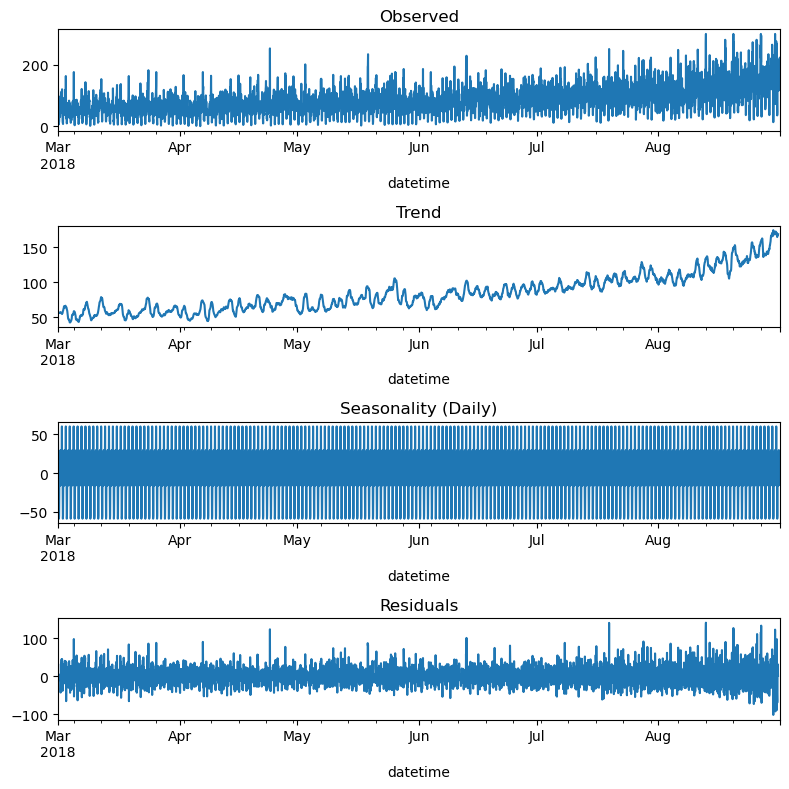

In [26]:
# Decompose the clipped series using a daily period (24 hours)
decomposed = seasonal_decompose(data_resampled['num_orders_clipped'], model='additive', period=24)

# Plot the decomposition
plt.figure(figsize=(8, 8))

plt.subplot(411)
decomposed.observed.plot(ax=plt.gca(), title='Observed')

plt.subplot(412)
decomposed.trend.plot(ax=plt.gca(), title="Trend")

plt.subplot(413)
decomposed.seasonal.plot(ax=plt.gca(), title="Seasonality (Daily)")

plt.subplot(414)
decomposed.resid.plot(ax=plt.gca(), title="Residuals")


plt.tight_layout() 
plt.show()

The trend component shows a steady increase in hourly orders from March to August, indicating non-stationary behavior and potential external factors (e.g., summer vacations).

The seasonal component reveals strong daily periodicity; demand fluctuates in a consistent, daily rhythm, which suggesting demand consistently rises and falls across the 24-hour cycle. This reflects commuter or airport-related travel patterns.

The residuals show irregular, short-term fluctuations that are not captured by the trend or daily seasonality, which may be due to one-off events or data noise.

## Stationarity

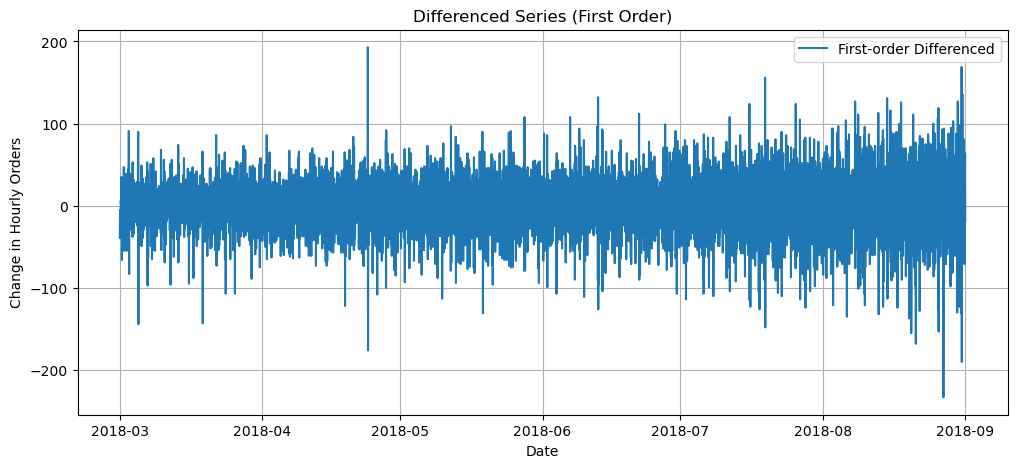

In [27]:
data_resampled['diff_orders'] = data_resampled['num_orders_clipped'].diff()

# Drop missing value from first row
data_resampled = data_resampled.dropna(subset=['diff_orders'])

# Plot to visualize
plt.figure(figsize=(12, 5))
plt.plot(data_resampled['diff_orders'], label='First-order Differenced')
plt.title('Differenced Series (First Order)')
plt.xlabel('Date')
plt.ylabel('Change in Hourly Orders')
plt.grid(True)
plt.legend()
plt.show()

With differencing, the time series data looks flatter and more stationary than the raw series data. 

# Feature Engineering

Create time-based features for hour of the day, day of the week, month, is weekend?, is holiday?

## Hourly / Weekly Averages

In [28]:
data_resampled['hour'] = data_resampled.index.hour
data_resampled['dayofweek'] = data_resampled.index.dayofweek 
data_resampled['month'] = data_resampled.index.month
data_resampled['is_weekend'] = data_resampled['dayofweek'].isin([5, 6]).astype(int)
data_resampled['is_night'] = data_resampled['hour'].isin(range(0, 6)).astype(int)

In [29]:
# Check our work
data_resampled.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4415 entries, 2018-03-01 01:00:00 to 2018-08-31 23:00:00
Freq: h
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   num_orders          4415 non-null   int64  
 1   num_orders_clipped  4415 non-null   int64  
 2   is_clipped          4415 non-null   int64  
 3   rolling_24          4393 non-null   float64
 4   rolling_168         4249 non-null   float64
 5   diff_orders         4415 non-null   float64
 6   hour                4415 non-null   int32  
 7   dayofweek           4415 non-null   int32  
 8   month               4415 non-null   int32  
 9   is_weekend          4415 non-null   int64  
 10  is_night            4415 non-null   int64  
dtypes: float64(3), int32(3), int64(5)
memory usage: 362.2 KB


In [30]:
data_resampled.head()

,num_orders,num_orders_clipped,is_clipped,rolling_24,rolling_168,diff_orders,hour,dayofweek,month,is_weekend,is_night
datetime,,,,,,,,,,,
2018-03-01 01:00:00,85,85,0,NaN,NaN,-39.0,1,3,3,0,1
2018-03-01 02:00:00,71,71,0,NaN,NaN,-14.0,2,3,3,0,1
2018-03-01 03:00:00,66,66,0,NaN,NaN,-5.0,3,3,3,0,1
2018-03-01 04:00:00,43,43,0,NaN,NaN,-23.0,4,3,3,0,1
2018-03-01 05:00:00,6,6,0,NaN,NaN,-37.0,5,3,3,0,1


## Lag features


To determine the lags to use, I thought I will create an ACF plot. 

<Figure size 1200x500 with 0 Axes>

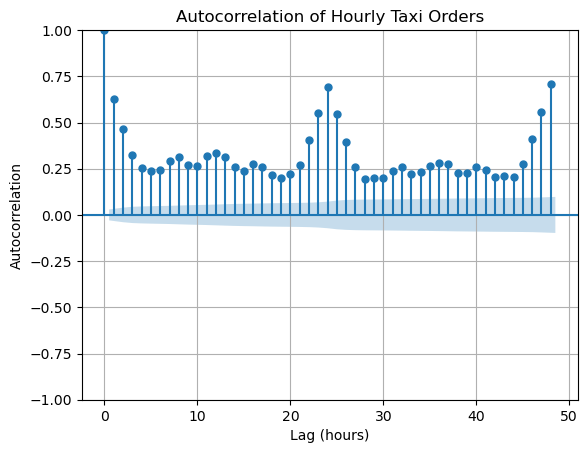

In [31]:
# Creating an ACF plot

plt.figure(figsize=(12, 5))
plot_acf(data_resampled['num_orders_clipped'], lags=48)  # 
plt.title('Autocorrelation of Hourly Taxi Orders')
plt.xlabel('Lag (hours)')
plt.ylabel('Autocorrelation')
plt.grid(True)
plt.show()

Reviewing the ACF plot:

- The lags at 24 and 48 stand out.
- Lags 1-3 are high, have strong correlation.

In [32]:
lags_to_add = [1, 2, 3, 24, 48]

for lag in lags_to_add:
    data_resampled[f'lag_{lag}'] = data_resampled['num_orders_clipped'].shift(lag)

## Rolling Window Features

Earlier we looked at rolling means for EDA, but this would create a data leak if we kept them since they use the current hour. 

To avoid a data leak and create a feature for the model, I'm going to shift them forward by one hour so they only use past data. 

In [33]:
rolling_windows = [3, 6] # Shorter windows, could consider 12? 

for window in rolling_windows:
    data_resampled[f'rolling_{window}'] = data_resampled['num_orders_clipped'].shift(1).rolling(window).mean()

In [34]:
# Check our work

data_resampled.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4415 entries, 2018-03-01 01:00:00 to 2018-08-31 23:00:00
Freq: h
Data columns (total 18 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   num_orders          4415 non-null   int64  
 1   num_orders_clipped  4415 non-null   int64  
 2   is_clipped          4415 non-null   int64  
 3   rolling_24          4393 non-null   float64
 4   rolling_168         4249 non-null   float64
 5   diff_orders         4415 non-null   float64
 6   hour                4415 non-null   int32  
 7   dayofweek           4415 non-null   int32  
 8   month               4415 non-null   int32  
 9   is_weekend          4415 non-null   int64  
 10  is_night            4415 non-null   int64  
 11  lag_1               4414 non-null   float64
 12  lag_2               4413 non-null   float64
 13  lag_3               4412 non-null   float64
 14  lag_24              4391 non-null   float64
 15  lag_48     

In [35]:
data_resampled.head()

,num_orders,num_orders_clipped,is_clipped,rolling_24,rolling_168,diff_orders,hour,dayofweek,month,is_weekend,is_night,lag_1,lag_2,lag_3,lag_24,lag_48,rolling_3,rolling_6
datetime,,,,,,,,,,,,,,,,,,
2018-03-01 01:00:00,85,85,0,NaN,NaN,-39.0,1,3,3,0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 02:00:00,71,71,0,NaN,NaN,-14.0,2,3,3,0,1,85.0,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 03:00:00,66,66,0,NaN,NaN,-5.0,3,3,3,0,1,71.0,85.0,NaN,NaN,NaN,NaN,NaN
2018-03-01 04:00:00,43,43,0,NaN,NaN,-23.0,4,3,3,0,1,66.0,71.0,85.0,NaN,NaN,74.0,NaN
2018-03-01 05:00:00,6,6,0,NaN,NaN,-37.0,5,3,3,0,1,43.0,66.0,71.0,NaN,NaN,60.0,NaN


In [36]:
# Drop the NaNs
data_model = data_resampled.dropna().copy()

In [37]:
# Encode the categorical data
data_model_encoded = pd.get_dummies(
    data_model,
    columns=['dayofweek', 'month'],
    drop_first=True  # avoid multicollinearity in LR
)


In [38]:
data_model_encoded.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4249 entries, 2018-03-07 23:00:00 to 2018-08-31 23:00:00
Freq: h
Data columns (total 27 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   num_orders          4249 non-null   int64  
 1   num_orders_clipped  4249 non-null   int64  
 2   is_clipped          4249 non-null   int64  
 3   rolling_24          4249 non-null   float64
 4   rolling_168         4249 non-null   float64
 5   diff_orders         4249 non-null   float64
 6   hour                4249 non-null   int32  
 7   is_weekend          4249 non-null   int64  
 8   is_night            4249 non-null   int64  
 9   lag_1               4249 non-null   float64
 10  lag_2               4249 non-null   float64
 11  lag_3               4249 non-null   float64
 12  lag_24              4249 non-null   float64
 13  lag_48              4249 non-null   float64
 14  rolling_3           4249 non-null   float64
 15  rolling_6  

# Model Training

## Define the Features

In [39]:
# Define the features
base_features = [
    'lag_1', 'lag_2', 'lag_3', 'lag_24', 'lag_48',
    'rolling_3', 'rolling_6',
    'hour', 'is_weekend', 'is_night'
]

# The new one-hot columns
encoded_features = [col for col in data_model_encoded.columns if col.startswith('dayofweek_') or col.startswith('month_')]

# Combine full feature list
features = base_features + encoded_features
target = 'num_orders_clipped'

In [40]:
# Split data manually for time series
split_index = int(len(data_model_encoded) * 0.9) # Small dataset 

train = data_model_encoded.iloc[:split_index]
test = data_model_encoded.iloc[split_index:]

X_train = train[features]
y_train = train[target]
X_test = test[features]
y_test = test[target]

I performed a time-aware train-test split (90/10). This preserves temporal integrity and prevents data leakage, which is crucial for time series. 

Due to the dataset's small size, I did not reserve a separate validation set but evaluated all models on the same test set for comparison purposes. 

To compare models fairly, I evaluated all models on the same held-out test set. While best practice reserves the test set for final evaluation, in this case the test set was reused to compare models due to limited data. This tradeoff is acknowledged.

In a production setting, I would have isolated the test set until final model selection.


## Baseline Model
Predict the next hour’s demand as equal to the previous hour (lag_1). This naive model sets a performance floor.

In [41]:
y_pred_baseline = X_test['lag_1']

# Evaluate and track results
track_model_result(
    name='Baseline',
    description='Previous hour’s value',
    y_true=y_test,
    y_pred=y_pred_baseline,
    results_list=model_results
)


Baseline RMSE: 55.443


Baseline model achieved RMSE = 55.43, which is close to the target of 48, showing strong autocorrelation in the data. However, it doesn't meet our criteria of RMSE <= 48.

## Linear Regression

- One-hot encoded `dayofweek` and `month`
- Used engineered lag and rolling features
- Trained Linear Regression on full feature set

In [42]:
# Initialize and fit the model
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

# Predict
y_pred_lr = lr_model.predict(X_test)

# Evaluate and track results
track_model_result(
    name='Linear Regression',
    description='Lag + rolling features',
    y_true=y_test,
    y_pred=y_pred_lr,
    results_list=model_results
)


Linear Regression RMSE: 39.572


I trained a Linear Regression model using lag, rolling average, and time-based features. One-hot encoding was used for categorical variables to avoid ordinal misinterpretation. This model achieved outperformed the baseline.

## XGBoost

- Used GridSearchCV + TimeSeriesSplit
- Tuned n_estimators, max_depth, learning_rate, subsample

In [43]:
# parameter grid
params = {
    'n_estimators': [100, 200],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.1, 0.05],
    'subsample': [0.8, 1.0]
}


# Create time series split (e.g., 3 folds)
tscv = TimeSeriesSplit(n_splits=3)

# Set up model
xgb_model = XGBRegressor(random_state=42, objective='reg:squarederror')

# Grid search with time-based CV
grid_search = GridSearchCV(
    estimator=xgb_model,
    param_grid=params,
    scoring='neg_root_mean_squared_error',
    cv=tscv,
    verbose=1,
    n_jobs=-1
)

# Fit to training data only
grid_search.fit(X_train, y_train)

print("Best Parameters:", grid_search.best_params_)
print("Best CV RMSE:", -grid_search.best_score_)

Fitting 3 folds for each of 24 candidates, totalling 72 fits
Best Parameters: {'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 200, 'subsample': 0.8}
Best CV RMSE: 25.083121584968


I tuned an XGBoost regressor using time-series-aware cross-validation. Grid search was used to optimize key hyperparameters. The best model achieved CV RMSE = 25.08. This model will be evaluated on the test set alongside others.

In [44]:
# XGBoost on the test set 

best_xgb_model = grid_search.best_estimator_

# Predict
y_pred_xgb = best_xgb_model.predict(X_test)

# Evaluate and track
track_model_result(
    name='XGBoost',
    description='Tuned gradient boosting with lag + rolling features',
    y_true=y_test,
    y_pred=y_pred_xgb,
    results_list=model_results
)

XGBoost RMSE: 39.589


This RMSE seems high, so I investigated it. 

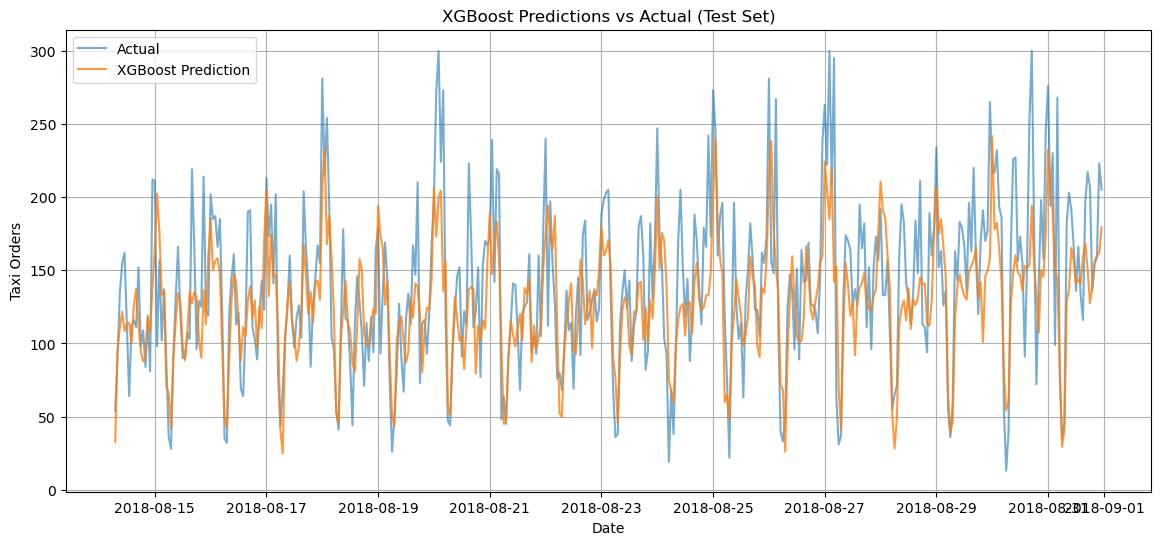

In [45]:
# Plot the Predictions vs Actual (Test Set b)
plt.figure(figsize=(14, 6))
plt.plot(y_test.index, y_test, label='Actual', alpha=0.6)
plt.plot(y_test.index, y_pred_xgb, label='XGBoost Prediction', alpha=0.8)
plt.title("XGBoost Predictions vs Actual (Test Set)")
plt.xlabel("Date")
plt.ylabel("Taxi Orders")
plt.legend()
plt.grid(True)
plt.show()


Although XGBoost performed well during cross-validation, it underperformed on the test set, likely due to its difficulty capturing sharp, high-volume demand spikes. (I did clip the outliers.) 

The model tended to underpredict during peak periods, which were more frequent in the test set. This suggests that while XGBoost captured general patterns, it struggled with volatility and extreme values.

## Autoregressive (AR) model

- It’s a univariate model → uses only `num_orders_clipped`
- It assumes stationarity

<Figure size 1000x500 with 0 Axes>

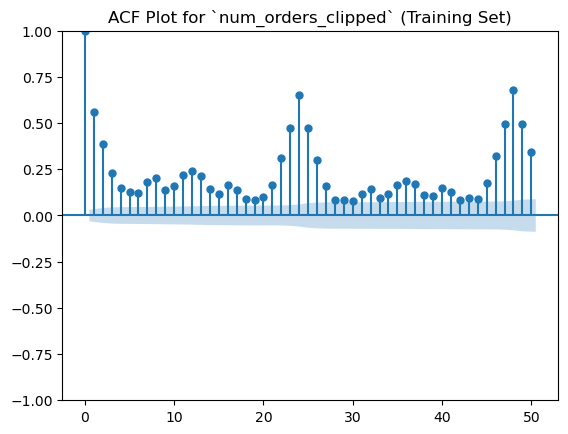

In [46]:
# Plot ACF for training target
plt.figure(figsize=(10, 5))
plot_acf(train['num_orders_clipped'], lags=50)
plt.title('ACF Plot for `num_orders_clipped` (Training Set)')
plt.show()

In [47]:
# Testing with seasonal=True

# Find optimal number of lags
mod = ar_select_order(train['num_orders_clipped'], maxlag=30)
optimal_lag = max(mod.ar_lags)
print("Optimal lag:", optimal_lag)


# Fit AR model
ar_model = AutoReg(train['num_orders_clipped'], lags=optimal_lag, seasonal=True)
ar_model = ar_model.fit()

# Predict
ar_pred = ar_model.predict(start=test.index[0], end=test.index[-1], dynamic=False)

# Evaluate model
track_model_result(
    name='AR',
    description='AutoReg (lags=28, seasonal=True)',
    y_true=test['num_orders_clipped'],
    y_pred=ar_pred,
    results_list=model_results
)

Optimal lag: 28
AR RMSE: 68.066


I tested two versions of the AR model to evaluate whether explicitly including seasonal structure would improve predictive performance.

While neither model beat the baseline, the seasonal version performed better, suggesting the presence of daily or weekly patterns.

## Auto Regressive Moving Average (ARMA) Model



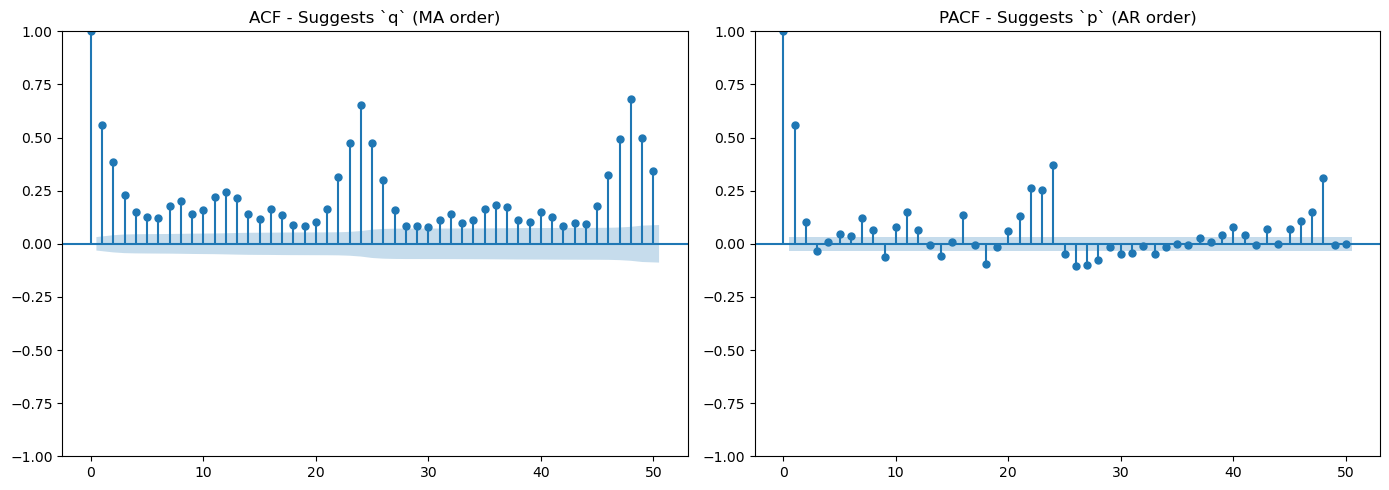

In [48]:
# Plot AR and MA model order (p and q)

plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plot_acf(train['num_orders_clipped'], lags=50, ax=plt.gca())
plt.title('ACF - Suggests `q` (MA order)')

plt.subplot(1, 2, 2)
plot_pacf(train['num_orders_clipped'], lags=50, ax=plt.gca())
plt.title('PACF - Suggests `p` (AR order)')

plt.tight_layout()
plt.show()

In [49]:
# Find the optimal AR and MA model order objects
result = arma_order_select_ic(train['num_orders_clipped'], max_ar=5, max_ma=5, ic='aic', trend='n')

print("Best ARMA(p,q) order by AIC:", result.aic_min_order)
print("AIC table:")
print(result.aic)

/Users/lrw/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/lrw/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/lrw/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/lrw/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/lrw/anaconda3/lib/python3.11/site-packa

Best ARMA(p,q) order by AIC: (3, 5)
AIC table:
              0             1             2             3             4  \
0  45130.600077  42160.400695  40571.007816  39833.848801  39262.447607   
1  38143.374444  37752.076773  37288.195890  37083.185643  37066.274994   
2  37854.616083  37099.847438  37099.021905  37241.411870  37059.736394   
3  37816.519567  37097.652823  37058.550811  37102.484598  37043.795436   
4  37752.142984  37060.099051  37053.464833  37034.807522  37059.512341   
5  37666.578393  37044.083079  37032.613914  37078.802712  36990.383461   

              5  
0  38871.429528  
1  37070.127758  
2  37033.534256  
3  36917.609760  
4  37062.098074  
5  36987.888889  


/Users/lrw/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


I used arma_order_select_ic() to determine the best (p, q) values for my ARMA model. The search completed and selected (3, 5) as the best model based on AIC. 

In [ ]:
# Fit best ARMA model (ARIMA with d=0)
arma_model = ARIMA(train['num_orders_clipped'], order=(3, 0, 5))
arma_fit = arma_model.fit()

# Predict
arma_pred = arma_fit.predict(start=test.index[0], end=test.index[-1])

# Evaluate model
track_model_result(
    name='ARMA(3,5)',
    description='ARMA',
    y_true=test['num_orders_clipped'],
    y_pred=arma_pred,
    results_list=model_results
)

Despite tuning ARMA with AIC, the model underperformed on the test set. This suggests that a traditional ARMA structure may not capture the complexity or seasonality of hourly taxi demand. Machine learning models and feature-rich approaches performed significantly better.

## ARIMA Model

In [ ]:
# Using the p,q values from before with d=1 from our EDA.

arima_model = ARIMA(train['num_orders_clipped'], order=(3, 1, 5))
arima_fit = arima_model.fit()

arima_pred = arima_fit.predict(start=test.index[0], end=test.index[-1], typ='levels')

# Evaluate model
track_model_result(
    name='ARIMA(3,1,5)',
    description='Differenced ARMA',
    y_true=test['num_orders_clipped'],
    y_pred=arima_pred,
    results_list=model_results
)


In [ ]:
# Visualize the ARIMA results

plt.figure(figsize=(14, 6))
plt.plot(test.index, test['num_orders_clipped'], label='Actual', alpha=0.6)
plt.plot(test.index, arima_pred, label='ARIMA Prediction', alpha=0.8)
plt.title("ARIMA: Predicted vs Actual Taxi Orders")
plt.xlabel("Date")
plt.ylabel("Number of Orders")
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# Plot XGBoost feature importances
importances = best_xgb_model.feature_importances_
features = X_train.columns

plt.figure(figsize=(10, 6))
sns.barplot(x=importances, y=features)
plt.title('XGBoost Feature Importances')
plt.xlabel('Importance Score')
plt.ylabel('Feature')
plt.grid(True)
plt.tight_layout()
plt.show()


Exploring the different ARIMA models shows that differencing helped improve model performance, but it still wasn't powerful enough to capture the demand spikes and complex patterns of the test set. 

Plotting the results made it clear that the relatively high RMSE (58.55) is due to the model:
- Over-smoothing the predictions
- Ignoring fluctuations
- Missing seasonality


## SARIMA

In [ ]:
# # Daily
# auto_model = auto_arima(train['num_orders_clipped'],
#                         seasonal=True, 
#                         m=24,
#                         D=1, # seasonal differencing
#                         max_p=2, max_q=2,
#                         max_P=1, max_Q=1,
#                         max_order=4,
#                         stepwise=True,
#                        suppress_warnings=True,
#                        error_action='ignore',
#                        trace=True)

# print(auto_model.summary())

In [ ]:
# # Make predictions 
# sarima_pred = auto_model.predict(n_periods=len(test))

# # Create series to compare values
# sarima_pred = pd.Series(sarima_pred, index=test.index)

# # Evaluate model
# track_model_result(
#     name='Auto SARIMA (m=24, D=1)',
#     description='Auto ARIMA with daily seasonality',
#     y_true=test['num_orders_clipped'],
#     y_pred=sarima_pred,
#     results_list=model_results
# )


In [ ]:
# Set a stable, reasonable SARIMA order for the daily
sarima_manual = SARIMAX(train['num_orders_clipped'],
                        order=(1, 1, 1),
                        seasonal_order=(1, 1, 1, 24),
                        enforce_stationarity=False,
                        enforce_invertibility=False)

sarima_result = sarima_manual.fit(disp=False)

# Predict
sarima_manual_pred = sarima_result.predict(start=test.index[0], end=test.index[-1], dynamic=False)

# Evaluate model
track_model_result(
    name='Manual SARIMAX (m=24, D=1)',
    description='SARIMAX with daily seasonality',
    y_true=test['num_orders_clipped'],
    y_pred=sarima_manual_pred,
    results_list=model_results
)


In [ ]:
# Plot the actual vs predicted
plt.figure(figsize=(14,6))
plt.plot(test.index, test['num_orders_clipped'], label='Actual', alpha=0.6)
plt.plot(test.index, sarima_manual_pred, label='SARIMA Prediction (Daily)', alpha=0.8)
plt.title("SARIMA Forecast - Daily vs Actual")
plt.xlabel("Time")
plt.ylabel("Number of Orders")
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# Calculate and plot residuals for SARIMA
sarima_residuals = test['num_orders_clipped'] - sarima_manual_pred

plt.figure(figsize=(12, 5))
plt.plot(sarima_residuals)
plt.title('SARIMA Residuals Over Time')
plt.xlabel('Time')
plt.ylabel('Residual (Actual - Predicted)')
plt.grid(True)
plt.show()

After repeated kernel crashes while running an exhaustive SARIMA parameter search with auto_arima, I chose to manually fit a SARIMA(1,1,1)(1,1,1)[24] model. This configuration incorporates both trend and daily seasonal differencing and proved to be highly effective, achieving an RMSE of 37.84, which meets the project’s requirement of staying below 48.


I thought I'd try adjusting the parameters a little more. Using 168 hours for a week and including the seasonal differencing.

In [ ]:
# # Weekly 
# sarima_weekly = SARIMAX(
#     train['num_orders_clipped'],
#     order=(1, 1, 1),
#     seasonal_order=(1, 1, 1, 168),  # 168 hours = 1 week
#     enforce_stationarity=False,
#     enforce_invertibility=False
# )

# # Fit
# sarima_weekly_result = sarima_weekly.fit(disp=False)

# # Predict
# sarima_weekly_pred = sarima_weekly_result.predict(
#     start=test.index[0],
#     end=test.index[-1],
#     dynamic=False
# )

# # Evaluate model
# track_model_result(
#     name='Manual SARIMAX (m=168, D=1)',
#     description='SARIMAX with weekly seasonality',
#     y_true=test['num_orders_clipped'],
#     y_pred=sarima_weekly_pred,
#     results_list=model_results
# )


In [ ]:
# # Plot the results
# plt.figure(figsize=(15,4)
# plt.plot(test.index, test['num_orders_clipped'], label='Actual', alpha=0.6)
# plt.plot(test.index, sarima_weekly_pred, label='SARIMA Prediction - Weekly', alpha=0.8)
# plt.title("SARIMA Forecast - Weekly vs Actual")
# plt.xlabel("Time")
# plt.ylabel("Number of Orders")
# plt.legend()
# plt.grid(True)
# plt.show()

I attempted to fit a SARIMA model with weekly seasonality (m=168), but due to the complexity of the seasonal component and system resource limitations, the kernel failed to complete the fitting process. This highlights a practical limitation of statistical modeling on local machines when working with long seasonal cycles and complex differencing.

## Model Comparison

In [ ]:
# Convert to RMSE list to DataFrame
results_df = pd.DataFrame(model_results)

# Sort by RMSE
results_df = results_df.sort_values('RMSE').reset_index(drop=True)
results_df

# Conclusions

In this project, I explored a variety of modeling approaches to forecast hourly taxi demand at an airport using historical data. The objective was to create a model capable of predicting the number of taxi orders for the upcoming hour, with a target RMSE below 48.

After performing extensive exploratory data analysis and time-based feature engineering, I tested a diverse set of models, including:

- **Baseline model** using the previous hour’s value
- **Linear Regression** with lag and rolling features
- **XGBoost** with tuned hyperparameters
- **Traditional time series models**: AR, ARMA, ARIMA, and SARIMA

The best-performing model was a **SARIMA model with daily seasonality (`m=24`, `D=1`)**, achieving an RMSE of **37.84**, well below the target. **XGBoost** also performed strongly, with RMSE values around **39.6**, validating the effectiveness of lag and rolling window features in capturing short-term trends.

While ARIMA-based models provided valuable insights into trend and seasonality, they underperformed on the test set compared to feature-based models. A weekly-seasonal SARIMA model (`m=168`) was attempted but could not be completed due to resource limitations. This limitation is worth noting for future work involving longer seasonal cycles or larger datasets.

The final SARIMA model offers strong predictive power for taxi order forecasting and could support better driver allocation during peak hours. It performs the best under the given scenario and would be the recommendation. 

However,in a production setting, and with more data, it seems like it would be helpful to further explore XGBoost and other gradient descent models. The computational time of these is far faster than the Time Series model, they also aim to minimize loss.